In [2]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [1]:
import json
import warnings
import nltk
import umap.umap_ as umap
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel, LdaModel
from wordcloud import WordCloud
# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# File paths
file_path = "W:\\Pictures\\Year 5\\Winter\\Data Mining\\Group Project\\arxiv-metadata-oai-snapshot.json"
#file_path = "C:\\Users\\siddh\\Downloads\\arxiv\\arxiv-metadata-oai-snapshot.json"
output_file_path = "cleaned_lemmatized_abstracts.txt"

# Setup
stop_words = set(word.lower() for word in stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Data holders
filtered_tokens_all = []
list_of_abstract_token_lists = []
abstract_count = 0
max_abstracts = 10000

# Open file to write cleaned abstracts
with open(output_file_path, "w", encoding="utf-8") as output_file:
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            if abstract_count >= max_abstracts:
                break
            try:
                json_object = json.loads(line)
                if "abstract" in json_object and json_object["abstract"].strip():
                    abstract = json_object["abstract"]

                    # Tokenize
                    tokens = word_tokenize(abstract)

                    # Clean and lemmatize
                    filtered = [
                        lemmatizer.lemmatize(word.lower(), pos='n')
                        for word in tokens
                        if word.isalpha() and word.lower() not in stop_words
                    ]

                    if filtered:
                        # Add to data holders
                        filtered_tokens_all.extend(filtered)
                        list_of_abstract_token_lists.append(filtered)
                        abstract_count += 1

                        # Write to file (one line per abstract)
                        output_file.write(" ".join(filtered) + "\n")

            except json.JSONDecodeError:
                continue

# Create DataFrame (summary of all tokens)
df_filtered = pd.DataFrame({
    'filtered_word_tokens': [filtered_tokens_all],
    'combined_abstract_cleaned': [" ".join(filtered_tokens_all)]
})

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19496\3373670771.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-da

In [2]:
# Uses the new file created which contains the cleaned and lemmatized abstracts
cleaned_file_path = "cleaned_lemmatized_abstracts.txt"

word_freq = Counter()

with open(cleaned_file_path, "r", encoding="utf-8") as file:
    for line in file:
        tokens = line.strip().split()
        word_freq.update(tokens)

# Shows the most common words
print("\nTop 50 most common words:")
for word, count in word_freq.most_common(50):
    print(f"{word}: {count}")


Top 50 most common words:
model: 5064
result: 3731
field: 3464
system: 3290
show: 3213
state: 2802
also: 2708
two: 2616
energy: 2602
using: 2438
theory: 2424
function: 2418
study: 2399
mass: 2331
quantum: 2291
one: 2136
present: 2032
data: 2017
star: 1998
equation: 1880
case: 1856
time: 1833
method: 1811
effect: 1776
paper: 1769
find: 1716
density: 1710
structure: 1709
phase: 1690
new: 1670
space: 1656
galaxy: 1656
property: 1642
parameter: 1640
distribution: 1588
number: 1557
order: 1536
solution: 1524
magnetic: 1481
large: 1444
temperature: 1439
spectrum: 1426
problem: 1393
different: 1387
based: 1350
observed: 1313
group: 1303
analysis: 1286
first: 1282
term: 1257


In [3]:
## NOTE: ONLY RUN THIS SECTION IF NEEDED SINCE IT TAKES A WHILE
# TF-IDF Vectorization
from tqdm import tqdm


cleaned_abstracts = []
with open(cleaned_file_path, "r", encoding="utf-8") as file:
    for line in file:
        cleaned_abstracts.append(line.strip())

tfidf_vec = TfidfVectorizer(max_features=5000, min_df = 5)
tfidf_mat = tfidf_vec.fit_transform(cleaned_abstracts)

# BERT (This runs for approx 5min)
def get_bert(text, batch_size=64):
    # Load pre-trained model and tokenizer
    # Using Distil Bert Tokenizer since it is much faster than regular Bert Tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Process in batches
    embeddings = []
    for i in tqdm(range(0, len(text), batch_size)):
        start = i
        end = start + batch_size
        batch_text = text[start:end]

        device = torch.device('cpu')
        model = model.to(device)


        # Tokenizing
        tokenized_text = tokenizer(batch_text, padding=True, truncation=True, max_length=512, return_tensors='pt')
        for key, val in tokenized_text.items():
            tokenized_text[key] = val.to(device)

        # Get Embeddings
        with torch.no_grad():
            output = model(**tokenized_text)

        # Update embeddings list
        embeddings.append(output.last_hidden_state[:, 0, :].numpy())

    # Cleanup Embeddings
    embeddings = np.vstack(embeddings)
    print("Embeddings: ")
    print(embeddings)
    return embeddings


bert_embedd = get_bert(cleaned_abstracts)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [18:25<00:00,  7.04s/it]

Embeddings: 
[[-0.39099535 -0.09850172 -0.23021983 ... -0.23009211  0.3081151
   0.11001073]
 [-0.31533834  0.05468257 -0.11013706 ... -0.19449955  0.3255644
   0.01272166]
 [-0.38865402 -0.0182808   0.05760095 ... -0.24178764  0.3533068
   0.22058795]
 ...
 [-0.54164934 -0.07462857 -0.22608589 ... -0.19731006  0.07098331
   0.2753523 ]
 [-0.294369   -0.1788786  -0.38277352 ... -0.04080642  0.10667773
   0.23228331]
 [-0.510643   -0.25334337 -0.1033466  ... -0.27798966  0.1183402
   0.4721526 ]]


In [4]:
# Dimensionality Reduction
from tqdm import tqdm

# Ignoring a few warnings being given
warnings.filterwarnings("ignore", category=FutureWarning)

# Variables
n_components = 2
perplexity = 30 # reduce when using more than 10,000 datasets
dence_tfidf_matrix = tfidf_mat.toarray() if hasattr(tfidf_mat, 'toarray') else tfidf_mat

# PCA with tfidf_matrix and bert
pca = PCA(n_components=n_components)
pca_tfidf = pca.fit_transform(dence_tfidf_matrix)
pca_bert = pca.fit_transform(bert_embedd)

# TSNE with tfidf_matrix and bert
tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=1000, random_state=42)#max_iter changed to n_iter
tsne_tfidf = tsne.fit_transform(dence_tfidf_matrix)
tsne_bert = tsne.fit_transform(bert_embedd)

# UMAP with tfidf_matrix and bert
u_map = umap.UMAP(n_components=n_components, random_state=42)
umap_tfidf = u_map.fit_transform(dence_tfidf_matrix)
umap_bert = u_map.fit_transform(bert_embedd)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
# Compare Representation Quality using Clustering
def evaluate_performance(embedding, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    fit_predicted_kmeans = kmeans.fit_predict(embedding)

    silhouette_sc = silhouette_score(embedding, fit_predicted_kmeans)
    davies_bouldin_sc = davies_bouldin_score(embedding, fit_predicted_kmeans)
    calinski_harabasz_sc = calinski_harabasz_score(embedding, fit_predicted_kmeans)

    return silhouette_sc, davies_bouldin_sc, calinski_harabasz_sc

scores = evaluate_performance(pca_tfidf)
print(f"PCA_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(pca_bert)
print(f"PCA_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(tsne_tfidf)
print(f"TSNE_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(tsne_bert)
print(f"TSNE_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(umap_tfidf)
print(f"UMAP_TFIDF: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

scores = evaluate_performance(umap_bert)
print(f"UMAP_BERT: Silhouette={scores[0]:.4f}, DBI={scores[1]:.4f}, CHI={scores[2]:.4f}")

PCA_TFIDF: Silhouette=0.3714, DBI=0.8201, CHI=10339.9056
PCA_BERT: Silhouette=0.3382, DBI=0.9041, CHI=7532.4475
TSNE_TFIDF: Silhouette=0.3854, DBI=0.8015, CHI=9809.1731
TSNE_BERT: Silhouette=0.3978, DBI=0.8145, CHI=11065.6890
UMAP_TFIDF: Silhouette=0.4341, DBI=0.7973, CHI=12252.3881
UMAP_BERT: Silhouette=0.4304, DBI=0.7948, CHI=13834.6175


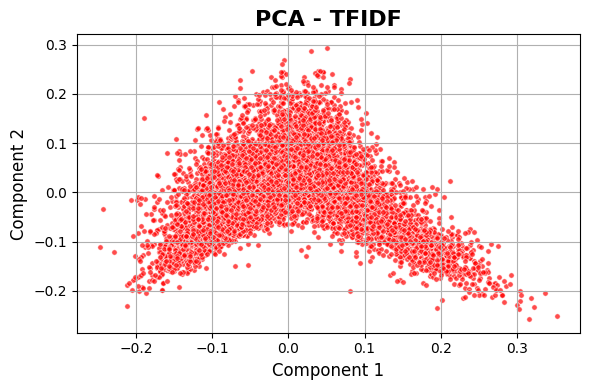

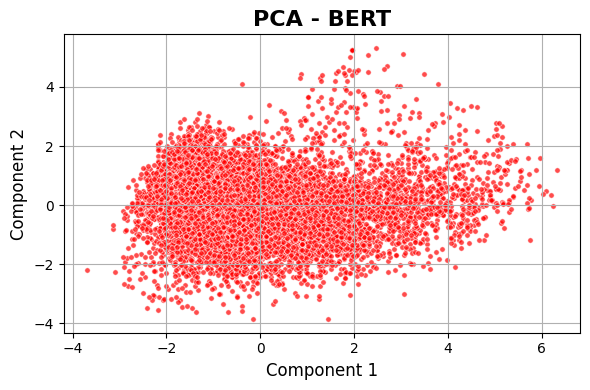

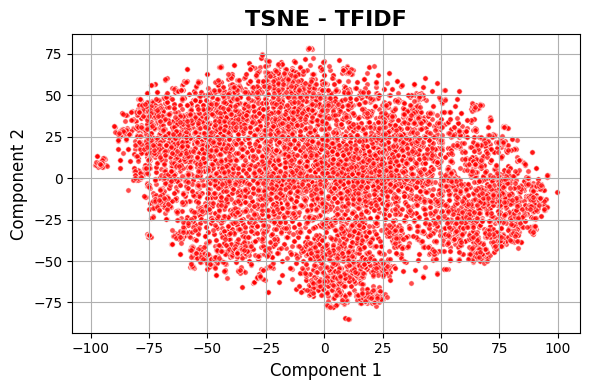

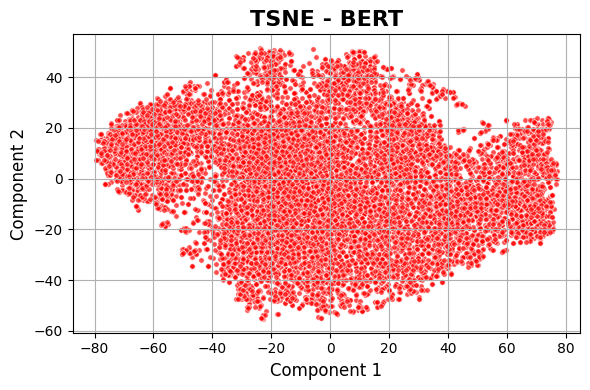

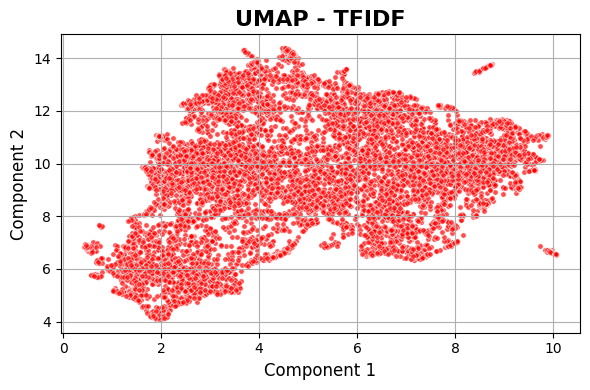

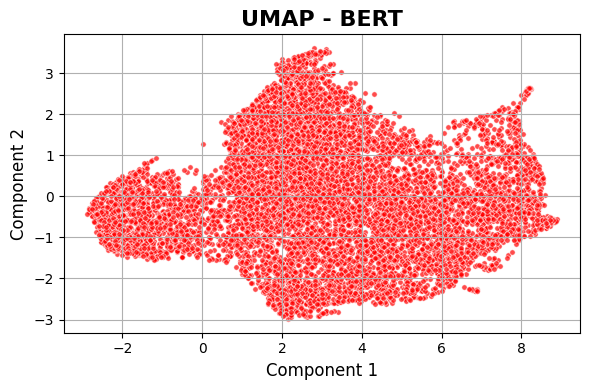

In [6]:
# Visualization of Paper Clusters
def plot_embeddings(embedding, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], alpha=0.7, s=15, linewidth=0.5, color='r')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Visualizing the reduced space
plot_embeddings(pca_tfidf, "PCA - TFIDF")
plot_embeddings(pca_bert, "PCA - BERT")
plot_embeddings(tsne_tfidf, "TSNE - TFIDF")
plot_embeddings(tsne_bert, "TSNE - BERT")
plot_embeddings(umap_tfidf, "UMAP - TFIDF")
plot_embeddings(umap_bert, "UMAP - BERT")

# Topic Modeling and Discovery

In [7]:
# Load the cleaned abstracts
with open(cleaned_file_path, "r", encoding="utf-8") as file:
    cleaned_abstracts = [line.strip().split() for line in file]

# Create dictionary
dictionary = corpora.Dictionary(cleaned_abstracts)
# Filter extremes (optional) - remove very rare and very common words
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Create corpus
corpus = [dictionary.doc2bow(abstract) for abstract in cleaned_abstracts]

In [8]:
coherence_values = []
model_list = []
print("check")

topic_range = range(5,51,5)
for num_topics in range(5, 51, 5):
    print(f"Training LDA model with {num_topics} topics...")
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        eta='auto'
    )
    model_list.append(model)

    coherencemodel = CoherenceModel(
        model=model,
        texts=cleaned_abstracts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_values.append(coherencemodel.get_coherence())

check
Training LDA model with 5 topics...
Training LDA model with 10 topics...
Training LDA model with 15 topics...
Training LDA model with 20 topics...
Training LDA model with 25 topics...
Training LDA model with 30 topics...
Training LDA model with 35 topics...
Training LDA model with 40 topics...
Training LDA model with 45 topics...
Training LDA model with 50 topics...


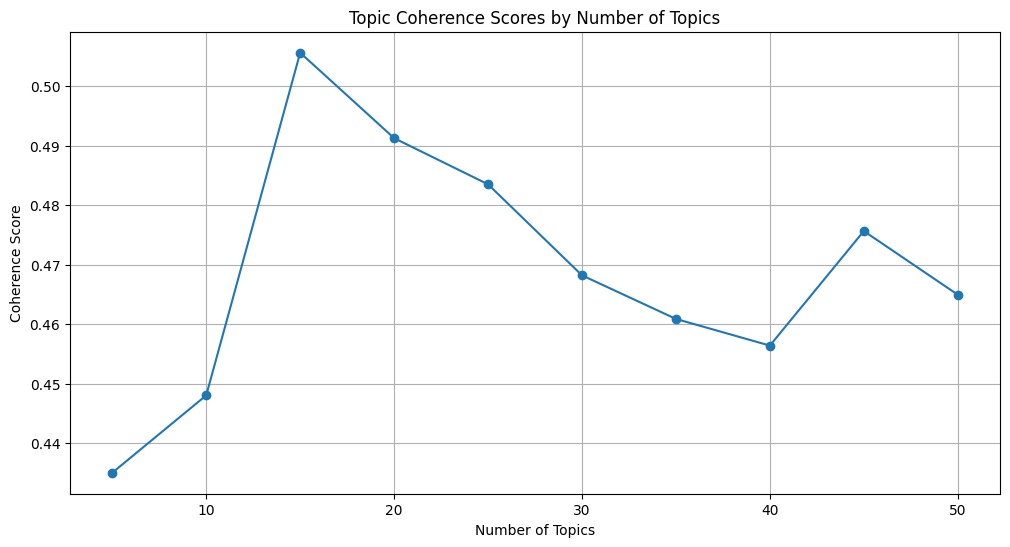

Number of Optimal Topic Choices from LDA Training 15


In [9]:
#Coherence scores
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_values, 'o-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores by Number of Topics')
plt.grid(True)
plt.savefig('topic_coherence_scores.png')
plt.show()

# Find the optimal number of topics
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_num_topics = topic_range[optimal_model_index]
optimal_model = model_list[optimal_model_index]
print(f"Number of Optimal Topic Choices from LDA Training {optimal_num_topics}")

In [10]:
# def get_document_topics_df(model, corpus, num_topics):
#     #document-topic distributions
#     doc_topic_matrix = np.zeros((len(corpus), num_topics))

#     for i, doc in enumerate(corpus):
#         doc_topics = model.get_document_topics(doc, minimum_probability=0)
#         for topic_id, prob in doc_topics:
#             doc_topic_matrix[i, topic_id] = prob

#     doc_topic_df = pd.DataFrame(
#         doc_topic_matrix,
#         columns=[f'Topic_{i}' for i in range(num_topics)]
#     )

#     return doc_topic_df

# def generate_topic_keywords_table(model, num_topics, num_words=15):
#     #table of topic keywords with probabilities
#     topic_keywords = []
#     for i in range(num_topics):
#         topic = model.show_topic(i, num_words)
#         topic_keywords.append([(word, round(prob, 4)) for word, prob in topic])

#     # Create DataFrame
#     df = pd.DataFrame()
#     for i in range(num_topics):
#         df[f'Topic {i}'] = pd.Series([x[0] for x in topic_keywords[i]])
#         df[f'Weight {i}'] = pd.Series([x[1] for x in topic_keywords[i]])

#     return df

In [11]:
#extract top words for number of optimal topic choices
words = {}

for id in range(optimal_num_topics):
    topic_words = optimal_model.show_topic(id, 10)
    words[f"Topic {id}"] = [topics for topics, _ in topic_words] #creates a dictionary entry of a list of the topic terms for each number of optimal topics

words_df = pd.DataFrame(words)
print(words_df)

  Topic 0      Topic 1      Topic 2   Topic 3      Topic 4    Topic 5  \
0       n         line    algorithm    theory        model     energy   
1   group     emission      network  equation         star   particle   
2       x       region      channel  solution     spectrum  collision   
3       g       source       system     field  observation     matter   
4       k          gas       scheme  function       source     cosmic   
5       p         dust        paper      term         time      model   
6   space  observation  performance  operator     observed     effect   
7       f        cloud  information      case     emission     photon   
8       r        radio         code     space         high  radiation   
9   prove   absorption      control   general      optical   universe   

     Topic 6     Topic 7       Topic 8      Topic 9     Topic 10   Topic 11  \
0       mass      galaxy         state         data        phase       star   
1      model     cluster   temperature

In [13]:
#discovered topics to for research domains

for id in range(len(words_df.columns)):
    top_words = words_df[f"Topic {id}"].tolist()

    print(f"Topic {id}: {', '.join(top_words[:10])}")

Topic 0: n, group, x, g, k, p, space, f, r, prove
Topic 1: line, emission, region, source, gas, dust, observation, cloud, radio, absorption
Topic 2: algorithm, network, channel, system, scheme, paper, performance, information, code, control
Topic 3: theory, equation, solution, field, function, term, operator, case, space, general
Topic 4: model, star, spectrum, observation, source, time, observed, emission, high, optical
Topic 5: energy, particle, collision, matter, cosmic, model, effect, photon, radiation, universe
Topic 6: mass, model, decay, neutrino, quark, standard, higgs, b, parameter, boson
Topic 7: galaxy, cluster, mass, halo, formation, dark, model, stellar, population, redshift
Topic 8: state, temperature, quantum, atom, optical, measurement, electron, entanglement, structure, molecule
Topic 9: data, method, result, analysis, new, used, model, using, measurement, present
Topic 10: phase, state, spin, model, transition, interaction, system, energy, lattice, temperature
Topic 1

In [14]:
#based on the discovered topics below maps them to the following research domains:
domain_map = {}

domain_map[0] = "Pure Mathematics & Group Theory"
domain_map[1] = "Astrophysical Medium & Radio Astronomy"
domain_map[2] = "Information Theory & Computer Networks"
domain_map[3] = "Mathematical Physics & Differential Equations"
domain_map[4] = "Observational Astronomy & Spectroscopy"
domain_map[5] = "Particle Physics & Cosmology"
domain_map[6] = "Standard Model & Particle Physics"
domain_map[7] = "Cosmology & Galaxy Formation"
domain_map[8] = "Quantum Physics & Atomic Physics"
domain_map[9] = "Data Analysis & Experimental Methods"
domain_map[10] = "Condensed Matter Physics"
domain_map[11] = "Stellar & Planetary Astrophysics"
domain_map[12] = "Fluid Dynamics & Electromagnetism"
domain_map[13] = "Theoretical Computer Science & Quantum Computing"
domain_map[14] = "Statistical Modeling & Complex Systems"
for id in range(len(words_df.columns)):
    top_words = words_df[f"Topic {id}"].tolist()
    domain_name = domain_map[id]

    print(f"{domain_name}: {', '.join(top_words[:10])}")


Pure Mathematics & Group Theory: n, group, x, g, k, p, space, f, r, prove
Astrophysical Medium & Radio Astronomy: line, emission, region, source, gas, dust, observation, cloud, radio, absorption
Information Theory & Computer Networks: algorithm, network, channel, system, scheme, paper, performance, information, code, control
Mathematical Physics & Differential Equations: theory, equation, solution, field, function, term, operator, case, space, general
Observational Astronomy & Spectroscopy: model, star, spectrum, observation, source, time, observed, emission, high, optical
Particle Physics & Cosmology: energy, particle, collision, matter, cosmic, model, effect, photon, radiation, universe
Standard Model & Particle Physics: mass, model, decay, neutrino, quark, standard, higgs, b, parameter, boson
Cosmology & Galaxy Formation: galaxy, cluster, mass, halo, formation, dark, model, stellar, population, redshift
Quantum Physics & Atomic Physics: state, temperature, quantum, atom, optical, me


Visualize topic distributions across the corpus


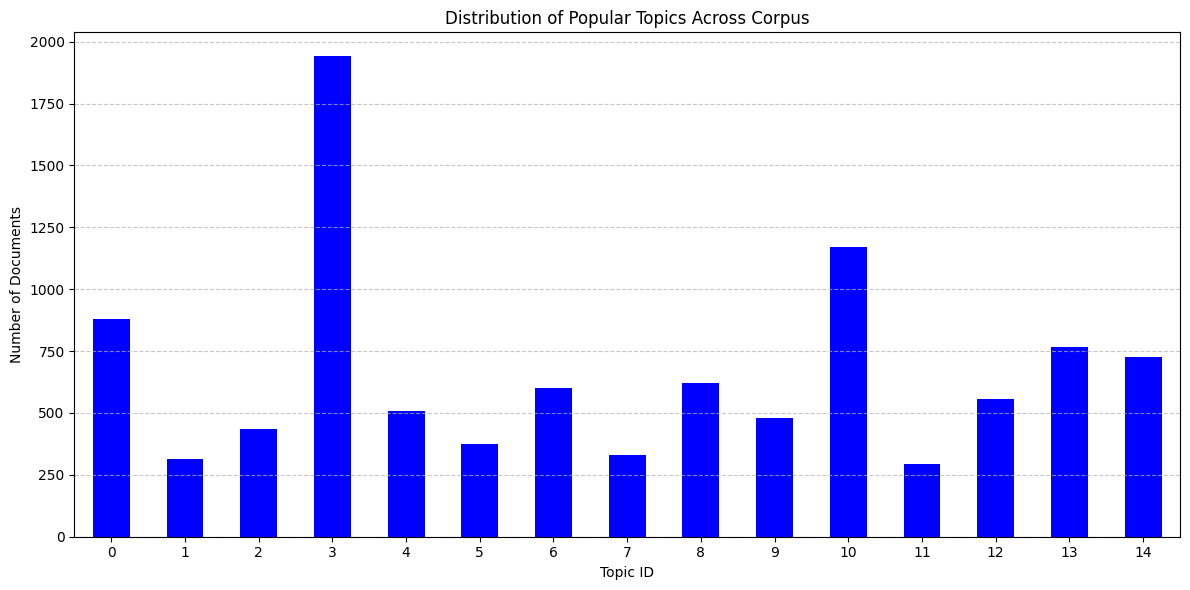

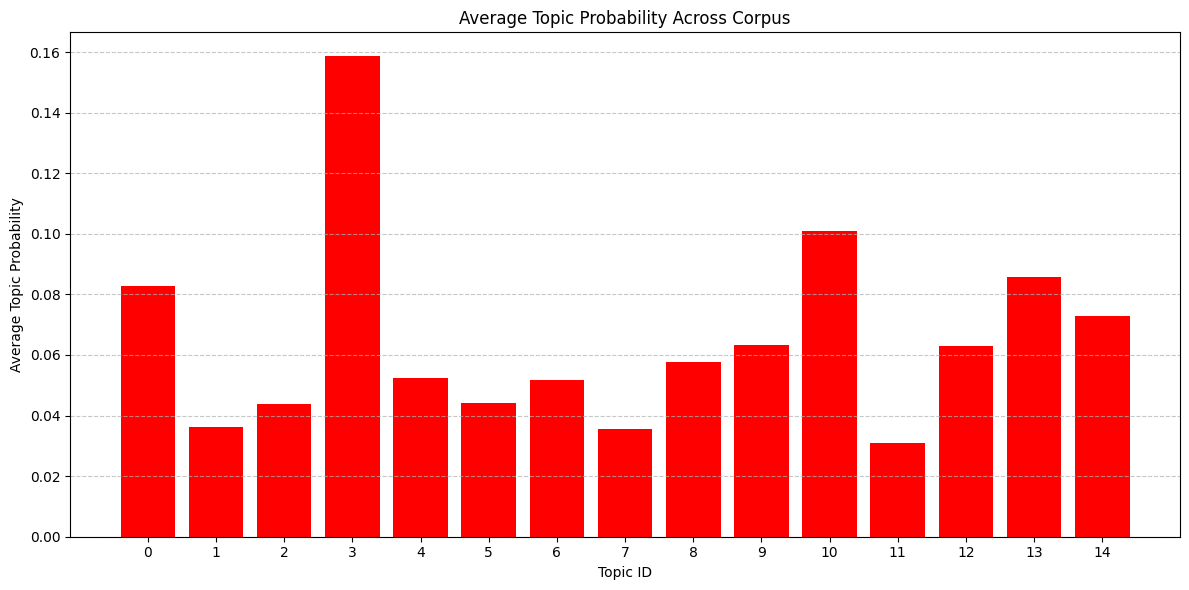

In [25]:
# Visualize Topic distributions across the corpus

print("\nVisualize topic distributions across the corpus")
doc_topics = [optimal_model.get_document_topics(doc) for doc in corpus]#topic distribution
dominant_topics = [max(doc_topic, key=lambda x: x[1])[0] if doc_topic else -1 for doc_topic in doc_topics]
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()#count dominat topics

plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='blue')
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.title('Distribution of Popular Topics Across Corpus')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()

#proability for each topic
topic_probs = [[0] * optimal_num_topics for _ in range(len(corpus))]
for i, doc_topic in enumerate(doc_topics):
    for topic_id, prob in doc_topic:
        topic_probs[i][topic_id] = prob
avg_topic_probs = np.mean(topic_probs, axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(optimal_num_topics), avg_topic_probs, color='red')
plt.xlabel('Topic ID')
plt.ylabel('Average Topic Probability')
plt.title('Average Topic Probability Across Corpus')
plt.xticks(range(optimal_num_topics))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('avg_topic_probability.png')
plt.show()

## Part 4: Classification Model Development

In this section, we will build classification models to predict research domains using the previously generated features. We'll use Naive Bayes, SVM, and Neural Networks, and compare their performance.

We will also apply Grid Search for hyperparameter optimization and evaluate the models using classification reports and accuracy scores.


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score


In [18]:
# Assuming labels are available in a CSV file
#labels = pd.read_csv('labels.csv')

# Using TF-IDF features from previous steps
#X = tfidf_mat
#y = labels['category']
y = pd.Series(dominant_topics)
is_valid_doc = y != -1
y = y[is_valid_doc]
X = tfidf_mat[is_valid_doc]

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully loaded and split into training and test sets.")


Data successfully loaded and split into training and test sets.


In [19]:
# Define parameter grid for Naive Bayes
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# Perform Grid Search
print("Performing Grid Search for Naive Bayes...")
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
best_nb_model = nb_grid_search.best_estimator_

# Predict and Evaluate
y_pred_nb = best_nb_model.predict(X_test)
print("Optimized Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Performing Grid Search for Naive Bayes...
Best Parameters for Naive Bayes: {'alpha': 0.1}
Optimized Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       178
           1       0.78      0.78      0.78        69
           2       0.81      0.67      0.73        87
           3       0.73      0.87      0.80       410
           4       0.74      0.84      0.79        97
           5       0.86      0.69      0.77        64
           6       0.87      0.86      0.86       134
           7       0.89      0.82      0.86        72
           8       0.72      0.66      0.69       109
           9       0.75      0.54      0.63        87
          10       0.73      0.83      0.78       218
          11       0.87      0.73      0.79        55
          12       0.82      0.66      0.73       110
          13       0.68      0.41      0.51       164
          14       0.71      0.72      0.72       146


In [20]:
# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 50],
    'kernel': ['linear', 'rbf', 'poly'],
}

# Perform Grid Search
print("Performing Grid Search for SVM...")
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters for SVM:", svm_grid_search.best_params_)
best_svm_model = svm_grid_search.best_estimator_

# Predict and Evaluate
y_pred_svm = best_svm_model.predict(X_test)
print("Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


Performing Grid Search for SVM...
Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Optimized SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       178
           1       0.81      0.78      0.79        69
           2       0.86      0.69      0.76        87
           3       0.74      0.90      0.81       410
           4       0.74      0.73      0.74        97
           5       0.77      0.67      0.72        64
           6       0.90      0.84      0.87       134
           7       0.87      0.83      0.85        72
           8       0.76      0.74      0.75       109
           9       0.62      0.56      0.59        87
          10       0.79      0.83      0.81       218
          11       0.91      0.71      0.80        55
          12       0.72      0.71      0.72       110
          13       0.74      0.55      0.63       164
          14       0.79      0.79      0.79       146

    accurac

In [21]:
# Define parameter grid for Neural Network
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500],
}

# Perform Grid Search
print("Performing Grid Search for Neural Network...")
nn_grid_search = GridSearchCV(MLPClassifier(random_state=42), nn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nn_grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters for Neural Network:", nn_grid_search.best_params_)
best_nn_model = nn_grid_search.best_estimator_

# Predict and Evaluate
y_pred_nn = best_nn_model.predict(X_test)
print("Optimized Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Performing Grid Search for Neural Network...
Best Parameters for Neural Network: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 200}
Optimized Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       178
           1       0.83      0.83      0.83        69
           2       0.82      0.71      0.76        87
           3       0.81      0.87      0.84       410
           4       0.80      0.73      0.76        97
           5       0.73      0.80      0.76        64
           6       0.88      0.85      0.86       134
           7       0.90      0.85      0.87        72
           8       0.73      0.72      0.72       109
           9       0.64      0.67      0.65        87
          10       0.80      0.85      0.82       218
          11       0.88      0.89      0.88        55
          12       0.76      0.72      0.74       110
          13       0.72      0.59     

In [23]:
# Final comparison of optimized models
print(f"Optimized Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print(f"Optimized SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Optimized Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn)}")


Optimized Naive Bayes Accuracy: 0.7565
Optimized SVM Accuracy: 0.7775
Optimized Neural Network Accuracy: 0.7895


In [26]:
#Interactive Topic Distribution (via pyLDAvis)
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

print("Interactive Visualization for Presentation")
vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
pyLDAvis.display(vis_data)

Interactive Visualization for Presentation


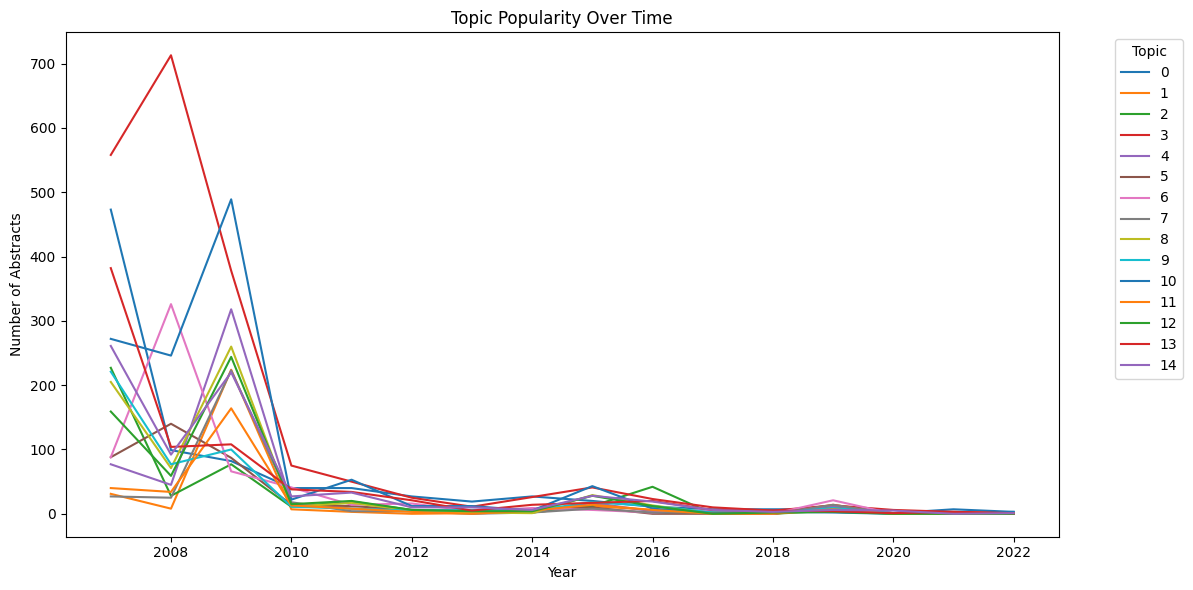

In [29]:
#dataframe of popular topic trends

years = [] #list of update years from the dataset

with open(file_path, "r", encoding="utf-8") as file:
    count = 0
    for line in file:
        if count >= max_abstracts:
            break
        try:
            json_object = json.loads(line)
            if "abstract" in json_object and json_object["abstract"].strip():
                # Extract year from ISO date format (YYYY-MM-DD)
                year = None
                
                # Try to get year from update_date
                if "update_date" in json_object:
                    date_str = json_object["update_date"]
                    # Extract year from the beginning of the string (first 4 characters)
                    if len(date_str) >= 4 and date_str[0:4].isdigit():
                        year = int(date_str[0:4])
                
                # If still no year, try other date fields
                if year is None and "versions" in json_object and len(json_object["versions"]) > 0:
                    for version in json_object["versions"]:
                        if "created" in version:
                            date_str = version["created"]
                            if len(date_str) >= 4 and date_str[0:4].isdigit():
                                year = int(date_str[0:4])
                                break
                
                # If still no year, use default
                if year is None:
                    year = 2000
                
                years.append(year)
                count += 1
        except json.JSONDecodeError:
            continue          

df = pd.DataFrame({'year': years,
    'dominant_topic': dominant_topics})
year_counts = df['year'].value_counts()
valid_years = year_counts[year_counts > 10].index.tolist()
filtered_df = df[df['year'].isin(valid_years)]


#Temporal Trend of Topic Popularity
topic_year_counts = filtered_df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)
topic_year_counts = topic_year_counts.sort_index()

topic_year_counts.plot(figsize=(12, 6), title="Topic Popularity Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Abstracts")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
#Identify Emerging & Declining Topics
# Calculate trend over time
topic_trend = topic_year_counts.pct_change().mean()
emerging_topics = topic_trend.sort_values(ascending=False).head(3)
declining_topics = topic_trend.sort_values().head(3)

print("Emerging Topics:")
print(emerging_topics)

print("\nDeclining Topics:")
print(declining_topics)


Emerging Topics:
dominant_topic
1    inf
2    inf
4    inf
dtype: float64

Declining Topics:
dominant_topic
3    -0.137053
13   -0.058636
0     0.121579
dtype: float64


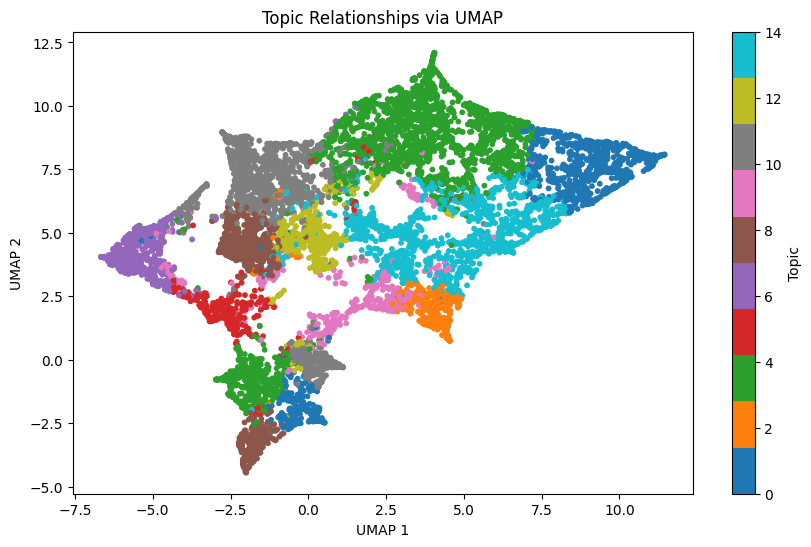

In [33]:
#Topic Relationships using UMAP
# Using UMAP on topic distributions
topic_distributions = optimal_model.get_document_topics(corpus, minimum_probability=0)
dense_topic_matrix = gensim.matutils.corpus2dense(topic_distributions, num_terms=optimal_model.num_topics).T

reducer = umap.UMAP()
embedding = reducer.fit_transform(dense_topic_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['dominant_topic'], cmap='tab10', s=10)
plt.title("Topic Relationships via UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Topic")
plt.show()


In [34]:
#Research Recommendations Based on Topics
# Display top keywords per emerging topic
for topic_id in emerging_topics.index:
    print(f"\nRecommended Research Area - Topic {topic_id}")
    print(", ".join([word for word, prob in optimal_model.show_topic(topic_id, topn=10)]))



Recommended Research Area - Topic 1
line, emission, region, source, gas, dust, observation, cloud, radio, absorption

Recommended Research Area - Topic 2
algorithm, network, channel, system, scheme, paper, performance, information, code, control

Recommended Research Area - Topic 4
model, star, spectrum, observation, source, time, observed, emission, high, optical
